## Тимонин Сергей
### Вариант 2
_______________________

# Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
- Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

In [1]:
import pandas as pd 
import requests 
from urllib.parse import urlencode 
from IPython.display import display_html
from itertools import chain,cycle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

In [2]:
# функция для автоматического обновления данных с Яндекс Диска
def ya_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

# подгружаем все файлы
groups_add = pd.read_csv(ya_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
groups     = pd.read_csv(ya_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';') 
active     = pd.read_csv(ya_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks     = pd.read_csv(ya_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

### Шаг 1. Подготовка и просмотр файлов
Перед тем как приступить к самому А/В тесту, посмотрим, что за данные были предоставлены, проверим их объем, дубликаты, пустые значения.

In [76]:
    # Из-за ошибки KeyError: 'href' (исчерпан лимит скачиваний файла) подгружу данные вручную, 
    # можно было оставить, думаю этот впорос не принципиально важен 
#groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',') 
#groups = pd.read_csv('Проект_2_groups.csv', sep=';') 
#active = pd.read_csv('Проект_2_active_studs.csv', sep=';') 
#checks = pd.read_csv('Проект_2_checks.csv', sep=';') 

In [7]:
# посмотрим на все дата фреймы, что вообще за данные нас ожидают
# чтобы не раздувать место для показа всех 4-ех df, применю функцию, которая разместить их на 1 строке
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [8]:
# посмотр всех предоставленные df
display_side_by_side(groups_add.head(5),groups.head(5),active.head(5),checks.head(5),\
                         titles=['groups_add','groups', 'active', 'checks'])

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B


In [9]:
# Так как структура данных у groups_add и groups иднетична, объединяю их в один df
groups_total = pd.concat([groups_add, groups])

In [10]:
display_side_by_side(groups_total.head(5),active.head(5),checks.head(5),\
                         titles=['groups_total','active', 'checks'])

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
,id,status_active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1


In [11]:
# посмотрим количество строк и столбцов в каждом df
print('Groups_total: строк и столбцов:', groups_total.shape) #Дополнительно проверю, чтобы конкатенация прошла успешно
print('Groups_add: строк и столбцов:', groups_add.shape)
print('Groups: строк и столбцов:', groups.shape)
print('Active: строк и столбцов:', active.shape)
print('Checks: строк и столбцов:', checks.shape)

Groups_total: строк и столбцов: (74576, 2)
Groups_add: строк и столбцов: (92, 2)
Groups: строк и столбцов: (74484, 2)
Active: строк и столбцов: (8341, 2)
Checks: строк и столбцов: (541, 3)


In [12]:
# посмотрим на наличие дубликатов
print('Groups_total: проверка дубликатов:', groups_total.duplicated().any())
print('Groups_add: проверка дубликатов:', groups_add.duplicated().any())
print('Groups: проверка дубликатов:', groups.duplicated().any())
print('Active: проверка дубликатов:', active.duplicated().any())
print('Checks: проверка дубликатов:', checks.duplicated().any())

Groups_total: проверка дубликатов: False
Groups_add: проверка дубликатов: False
Groups: проверка дубликатов: False
Active: проверка дубликатов: False
Checks: проверка дубликатов: False


In [13]:
# посмотрим на наличие пустых ячеек
print('Groups_total: проверка пустых ячеек:', groups_total.isna().sum())
print('Groups_add: проверка пустых ячеек:', groups_add.isna().sum())
print('Groups: проверка пустых ячеек:', groups.isna().sum())
print('Active: проверка пустых ячеек:', active.isna().sum())
print('Checks: проверка пустых ячеек:', checks.isna().sum())

Groups_total: проверка пустых ячеек: id     0
grp    0
dtype: int64
Groups_add: проверка пустых ячеек: id     0
grp    0
dtype: int64
Groups: проверка пустых ячеек: id     0
grp    0
dtype: int64
Active: проверка пустых ячеек: id               0
status_active    0
dtype: int64
Checks: проверка пустых ячеек: id            0
rev           0
status_rev    0
dtype: int64


### Шаг 2. Работа внутри DataFrame
Ок, данные выверены по ним вопросов нет, далее определяю метрики, которые буду прорабатывать. Так как я сначала выполнил задания 2 и 3, только потом приступил к 1-му, поэтому набор метрик будет такой-же как и во 2 и 3 заданиях, а именно:
- ARPU - (Average Revenue Per User), т.е. средний доход на пользователя
- ARPPU - (Average Revenue Per Active User), т.е. средний доход платящего на пользователя
- CR - (Сonversion rate), т.е. коэффициент конверсии

In [14]:
# создаем колонки с признаками активного пользователя и платящего пользователя, 
# чтобы в дальнешем было удобнее ориентироваться в данных
active['status_active'] = 1
checks['status_rev'] = 1
# переименовываем столбцы, чтобы было удобно сцепить и делать merge всех df
active=active.rename(columns={'student_id':'id'})
checks=checks.rename(columns={'student_id':'id'})
# объединяем все df
df_t1=groups_total.merge(checks, how='left', on='id').merge(active, how='left', on='id')
df_t1=df_t1.fillna(0)
df_t1.head(5)

,id,grp,rev,status_rev,status_active
0,5694584,B,0.0,0.0,0.0
1,5694830,B,0.0,0.0,0.0
2,5695057,B,0.0,0.0,0.0
3,5698872,B,0.0,0.0,0.0
4,5699067,B,0.0,0.0,0.0


Итак, так как были определены метрики ARPU, ARPPU и CR, теперь посмотрю общие данные по ним

In [15]:
df_agg_t1=df_t1.groupby(['grp'], as_index=False)\
                    .agg({'rev': 'sum', 'id': 'count', 'status_rev':'sum', 'status_active':'sum' })\
                    .rename(columns={'id':'count_id', 'status_rev':'count_id_with_payment'})
df_agg_t1['ARPU']=df_agg_t1['rev']/df_agg_t1['count_id']
df_agg_t1['ARPPU']=df_agg_t1['rev']/df_agg_t1['count_id_with_payment']
df_agg_t1['CR']=df_agg_t1['count_id_with_payment']/df_agg_t1['count_id']*100
df_agg_t1

,grp,rev,count_id,count_id_with_payment,status_active,ARPU,ARPPU,CR
0,A,92096.0000,14693,107.0,1538.0,6.268019,860.710280,0.728238
1,B,481230.0036,59883,434.0,6803.0,8.036171,1108.824893,0.724747


Для дальнейшего анализа я сосредоточусь только на активных пользователях, то есть на тех, кто содержится в файле 'active_stud'. Ранее я создал отдельный признак 'status_active' со значением '1', что позволит мне удобно фильтровать и работать именно с этой группой пользователей.

Обратим внимание, что в дальнейшем мои тестирования исключительно ориентированы на эту подвыборку активных пользователей. Это связано с тем, что общая база данных может содержать устаревшую информацию, не актуальную на текущий момент.

Стоит отметить, что две выборки (группы A и B) существенно отличаются по размеру, что может вызывать сомнения относительно адекватности статистической оценки различий. В таких случаях необходимо тщательно проанализировать результаты и учитывать особенности каждой выборки при интерпретации результатов тестирования.
- в группе **А** 14 693 пользователя (19,7%)
- в группе **В** 59 883 пользователя (80,3%)

Также, если рассматривать группу с активными пользователям, то соотношением примерно такое же.
- в группе **А** 1 538 пользователя (18,4%)
- в группе **В** 6 803 пользователя (81,6%)

In [16]:
# посмотрим ARPU по группам
df_agg_t2_arpu=df_t1[(df_t1.status_active == 1)].groupby(['grp'], as_index=False)\
                    .agg({'rev': 'mean'})
df_agg_t2_arpu

,grp,rev
0,A,47.347204
1,B,58.058798


In [17]:
# ARPPU по группам
df_agg_t2_arppu=df_t1[((df_t1.status_active == 1) & (df_t1.status_rev == 1))].groupby(['grp'], as_index=False)\
                    .agg({'rev': 'mean'})
df_agg_t2_arppu

,grp,rev
0,A,933.589744
1,B,1257.878992


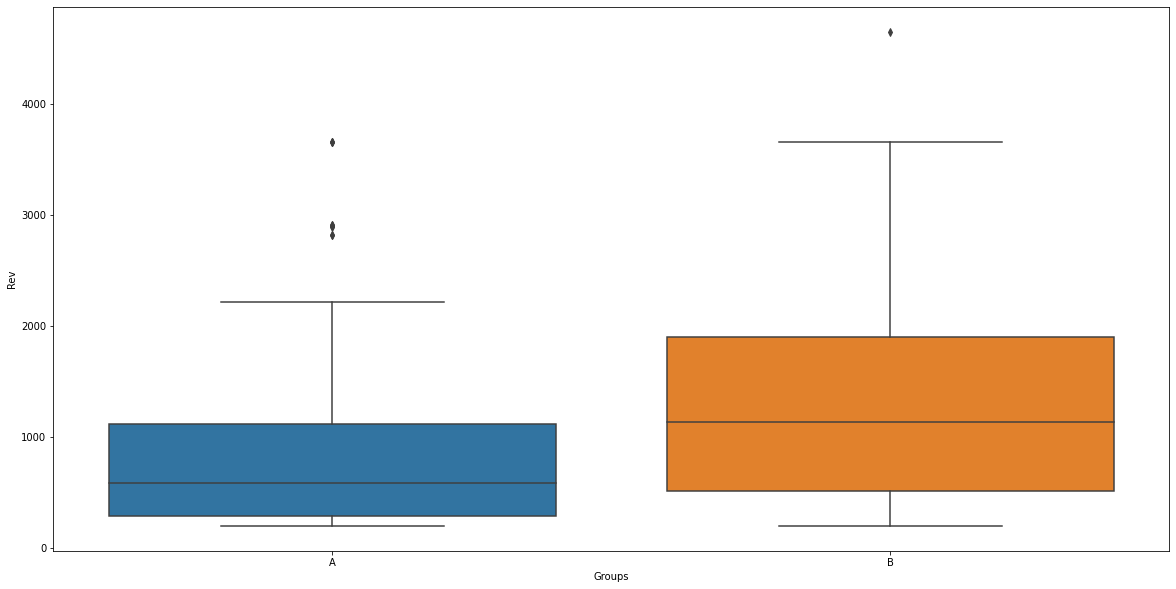

In [18]:
# визузализируем, чтобы проверить средние и посомтреть наличие выбросов
df_filtered = df_t1[((df_t1.status_active == 1) & (df_t1.status_rev == 1))].sort_values('grp')
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=df_filtered)
plt.xlabel('Groups')
plt.ylabel('Rev')
plt.show()

### Шаг 3. Приступаю к А/В тестированию.
Формулирую нулевую и альтернативную гипотезы:
- H0 (нулевая гипотеза): Нет статистически значимой разницы между данными группами.
- H1 (альтернативная гипотеза): Соответственно, статистически значимая разница существует.

In [19]:
# берем данные только по активным пользователям
df_au=df_t1[(df_t1.status_active == 1)]
df_au.head()

,id,grp,rev,status_rev,status_active
7,5700613,B,0.0,0.0,1.0
39,5723133,A,0.0,0.0,1.0
40,5723648,B,0.0,0.0,1.0
43,5728431,B,0.0,0.0,1.0
44,5729371,A,0.0,0.0,1.0


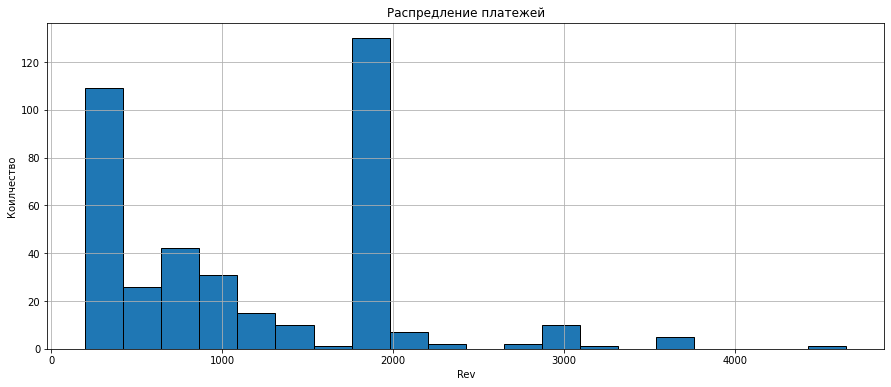

In [20]:
# посмотрим на распеределение платежей, чтобы опрделиться каким именно тестом пользоваться.
df_graf=df_au[(df_au.status_rev == 1)]
plt.figure(figsize=(15, 6)) 
plt.hist(df_graf['rev'], bins=20, edgecolor='black')
plt.xlabel('Rev') 
plt.ylabel('Коилчество') 
plt.title('Распредление платежей') 
plt.grid(True)  
plt.show()  

### Шаг 4. Выбор метода. Так как распределение не является нормальным, буду использовать тестирование через критерий Манна-Уитни 

Для этого:
1. Подготавлиеваем данные
2. Определяем и расчитываем метрики
3. Применяем критерий Манна-Уитни
8. Получаем p-value

In [17]:
# разделяю df на два, по группам А и В
group_a=df_au[df_au['grp'] =='A']
group_b=df_au[df_au['grp'] =='B']

# выполняем тест Манна-Уитни для ARPU
statistic_arpu, p_value_arpu=mannwhitneyu(group_a['rev']\
                                            , group_b['rev']\
                                            , alternative='two-sided') #рассматриваем различия в обе стороны (как + так и -)

# для ARPPU
statistic_arppu, p_value_arppu=mannwhitneyu(group_a[group_a['status_rev']==1]['rev']\
                                              , group_b[group_b['status_rev'] == 1]['rev']\
                                              , alternative='two-sided') #рассматриваем различия в обе стороны (как + так и -)

# для CR
statistic_cr, p_value_cr=mannwhitneyu(group_a['status_rev']\
                                        , group_b['status_rev']\
                                        , alternative='two-sided') #рассматриваем различия в обе стороны (как + так и -)

# вывожу результаты
print("ARPU:")
print("U-статистика =", statistic_arpu)
print("p-value =", p_value_arpu)

print("\nARPPU:")
print("U-статистика =", statistic_arppu)
print("p-value =", p_value_arppu)

print("\nCR:")
print("U-статистика =", statistic_cr)
print("p-value =", p_value_cr)

# проверяем p-value на стат. значимость
if p_value_arpu< 0.05:
    print("\n ARPU: Отклоняем H0. Существует статистически значимая разница между группами А и В")
else:
    print("\nARPU:  Не отклоняем H0. Нет статистически значимой разницы между группами А и В")

if p_value_arppu < 0.05:
    print("ARPPU: Отклоняем H0. Существует статистически значимая разница между группами А и В")
else:
    print("ARPPU: Не отклоняем H0. Нет статистически значимой разницы между группами А и В")

if p_value_cr < 0.05:
    print("CR: Отклоняем H0. Существует статистически значимая разница между группами А и В")
else:
    print("CR:    Не отклоняем H0. Нет статистически значимой разницы между группами А и В")

ARPU:
U-статистика = 5252113.0
p-value = 0.5099747992861601

ARPPU:
U-статистика = 9001.0
p-value = 0.0002511393831406922

CR:
U-статистика = 5255358.0
p-value = 0.4455071016631552

ARPU:  Не отклоняем H0. Нет статистически значимой разницы между группами А и В
ARPPU: Отклоняем H0. Существует статистически значимая разница между группами А и В
CR:    Не отклоняем H0. Нет статистически значимой разницы между группами А и В


### Вывод по Манну-Уитни:

**- ARPU (средний доход на пользователя):**
- **Не отклоняем H0**
- Средний доход на пользователя не сильно отличается в разных группах.
- Разница в среднем доходе на пользователя между группами A и B статистически незначима.

**- ARPPU (средний доход платящего на пользователя):**
- **Отклоняем H0**
- В группе B средний доход на платящего пользователя значительно выше, чем в группе A.
- Разница в среднем доходе на платящего пользователя между группами A и B является статистически значимой.


**- CR (Conversion Rate - Доля пользователей, совершивших оплату):**
- **Не отклоняем H0**
- Разница в доле пользователей, совершивших оплату, между группами A и B статистически незначима.
- Обе группы имеют примерно одинаковую долю пользователей, которые совершают оплату.


______________________

### Также, проведу тестирование через Bootstrap:

Для этого:
1. Подготавлиеваем данные
2. Определяем и расчитываем метрики
3. Определяем количество повторений/выборок (чем больше, тем выше точность результатов)
4. Генерируем выборки
5. Рассчитываем метрики по выборкам
6. Вычисляем наблюдаемую статистику (из оригинальных данных) 
7. Вычисляем статистику на основе сгенерированныз выборок/перестановок
8. Получаем p-value

### Шаг 1. Подготовим данных и раздедение на соответствующие группы:

In [42]:
# разделяем данные на две группы для ARPU
group_a_arpu=df_au[df_au['grp']=='A']['rev'].values
group_b_arpu=df_au[df_au['grp']=='B']['rev'].values

# для ARPPU
group_a_arppu=df_au[(df_au['grp']=='A') & (df_au['status_rev']==1)]['rev'].values
group_b_arppu=df_au[(df_au['grp']=='B') & (df_au['status_rev']==1)]['rev'].values

# для CR
group_a_cr=df_au[(df_au['grp']=='A') & (df_au['status_active']==1)]['status_rev'].values
group_b_cr=df_au[(df_au['grp']=='B') & (df_au['status_active']==1)]['status_rev'].values

# задаем количество повторений в Bootstrap
samples = 1000

# создаем общую функцию для вычисления метрик
def bootstrap_func(sample):
    return sample.mean()

### Шаг 2. Смотрим p-value для ARPU

In [47]:
# Bootstrap анализ и перестановка
arpu_a = np.random.choice(group_a_arpu, size=(samples, len(group_a_arpu)), replace=True)
arpu_b = np.random.choice(group_b_arpu, size=(samples, len(group_b_arpu)), replace=True)

metrics_arpu_a = np.apply_along_axis(bootstrap_func, axis=1, arr=arpu_a)
metrics_arpu_b = np.apply_along_axis(bootstrap_func, axis=1, arr=arpu_b)

# рассчитываем фактическую статистику на основе исходных данных
orig_stat_arpu = group_b_arpu.mean() - group_a_arpu.mean()
# рассчитываем статистики из выборок/перестановок
per_stat_arpu = metrics_arpu_b - metrics_arpu_a 
# рассчитываем p-value
p_value_arpu = (np.abs(per_stat_arpu) >= np.abs(orig_stat_arpu)).mean()

print(f"p-value ARPU: {p_value_arpu:.5f}")

p-value ARPU: 0.52200


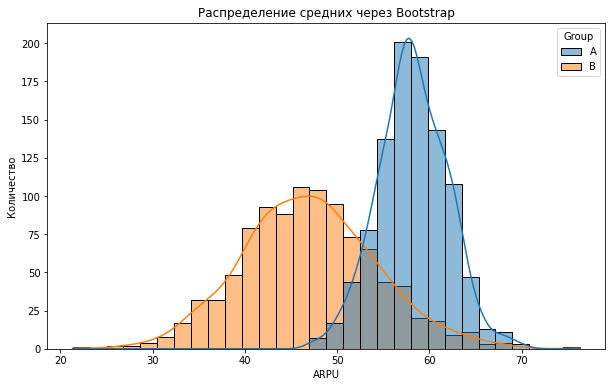

In [62]:
# визуализируем распределение средних ARPU по группам
df_vis = pd.DataFrame({'Group': ['A'] * samples + ['B'] * samples,
                       'ARPU': np.concatenate([metrics_arpu_b, metrics_arpu_a])})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_vis, x='ARPU', hue='Group', kde=True, bins=30)
plt.xlabel('ARPU')
plt.ylabel('Количество')
plt.title('Распределение средних через Bootstrap')
plt.show()

**ARPU (средний доход на пользователя):**
- P_values = 52%, что сильно выше значения уровня значимости (5%), в соответствие с чем, **не отклоняем H0**

### Шаг 3. Смотрим p-value для ARPPU

In [48]:
arppu_a = np.random.choice(group_a_arppu, size=(samples, len(group_a_arppu)), replace=True)
arppu_b = np.random.choice(group_b_arppu, size=(samples, len(group_b_arppu)), replace=True)

metrics_arppu_a = np.apply_along_axis(bootstrap_func, axis=1, arr=arppu_a)
metrics_arppu_b = np.apply_along_axis(bootstrap_func, axis=1, arr=arppu_b)

orig_stat_arppu = arppu_b.mean() - arppu_a.mean()
per_stat_arppu = metrics_arppu_b - metrics_arppu_a
p_value_arppu = (np.abs(per_stat_arppu) >= np.abs(orig_stat_arppu)).mean()

print(f"p-value ARPPU: {p_value_arppu:.5f}")

p-value for ARPPU: 0.52800


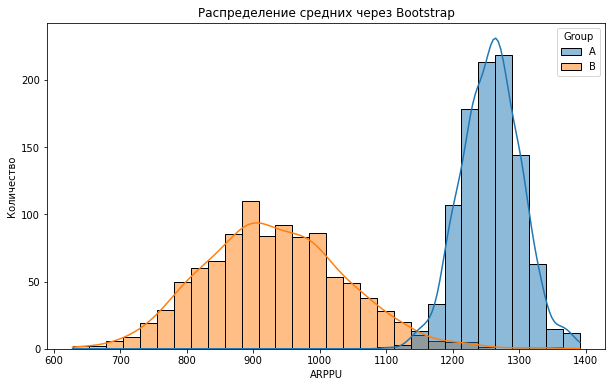

In [64]:
df_vis = pd.DataFrame({'Group': ['A'] * samples + ['B'] * samples,
                       'ARPPU': np.concatenate([metrics_arppu_b, metrics_arppu_a])})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_vis, x='ARPPU', hue='Group', kde=True, bins=30)
plt.xlabel('ARPPU')
plt.ylabel('Количество')
plt.title('Распределение средних через Bootstrap')
plt.show()

**ARPPU (средний доход на платящего пользователя):**
- P_values = 53%, что сильно выше значения уровня значимости (5%), в соответствие с чем, **не отклоняем H0**

###  Шаг 4. Смотрим p-value для CR

In [68]:
cr_a = np.random.choice(group_a_cr, size=(samples, len(group_a_cr)), replace=True)
cr_b = np.random.choice(group_b_cr, size=(samples, len(group_b_cr)), replace=True)

metrics_cr_a = np.apply_along_axis(bootstrap_func, axis=1, arr=cr_a)
metrics_cr_b = np.apply_along_axis(bootstrap_func, axis=1, arr=cr_b)

orig_stat_cr = group_b_cr.mean() - group_a_cr.mean()
per_stat_cr = metrics_cr_b - metrics_cr_a
p_value_cr = (np.abs(per_stat_cr) >= np.abs(orig_stat_cr)).mean()

print(f"p-value CR: {p_value_cr:.5f}")

p-value CR: 0.55300


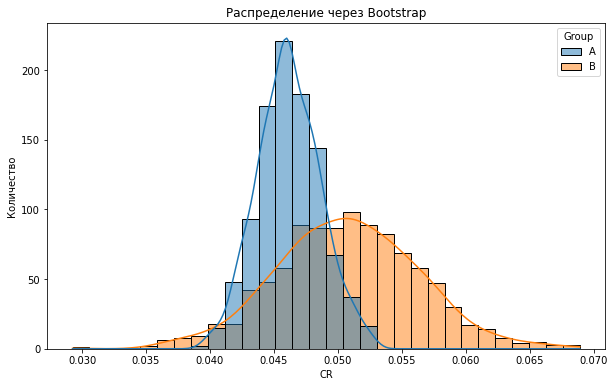

In [69]:
df_vis = pd.DataFrame({'Group': ['A'] * samples + ['B'] * samples,
                       'CR': np.concatenate([metrics_cr_b, metrics_cr_a])})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_vis, x='CR', hue='Group', kde=True, bins=30)
plt.xlabel('CR')
plt.ylabel('Количество')
plt.title('Распределение через Bootstrap')
plt.show()

**CR:**
- P_values = 55%, что сильно выше значения уровня значимости (5%), в соответствие с чем, **не отклоняем H0**

### Общий вывод:
P-value для всех трех метрик (ARPU, ARPPU и CR) составляет порядка 52-55%, также была замечена разница в количестве строк в выборках для групп A и B (в соотношение 80% / 20%), исходя из этого можно сделать следующие выводы:

1. **ARPU, ARPPU и CR**: Высокие p-value указывают на то, что нет статистически значимых различий между группами нет ни по одной из метрик. Это может означать, что разница в общих метриках в разных группах могут быть результатом случайной вариации, а не систематической разницы между группами. Альтернативную гипотезу H1 рекомендуется отклонить.

2. **Разница в размерах выборок**: Различие в количестве строк между группами (80% в одной группе и 20% в другой) может оказать значительное вияние на статистические тесты. В данном случае, небольшое количество данных в исследуемой группе B  может сказаться на точности и надежности результатов. Альтернативную гипотезу H1 рекомендуется отклонить.

3. **Доверительные интервалы**: Довериительный интервал у группы тестовой группы B более узкий, что может говорить о том, что данные в тестовой выборке более однородны и предсказуемы.

**Рекомендации:** Увеличенить размеров выборок, что может помочь уменьшить случайную вариацию и повысить статистическую мощность тестов.

----------------------------------

-----------------------------

# Задание 2. SQL
### 2.1 Очень усердные ученики.
#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

#### 2.1.2 Задача
Дана таблица *default.peas*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   timest  | timestamp| Время решения карточки|
|   correct  | bool| 	Правильно ли решена горошина?|
|   subject  | text| Дисциплина, в которой находится горошина|

#### Решение:
Так как в задание указано, что данные нужно смотреть за "текущий месяц", а в таблице только данные за 2021 год, оставлю выбор года и месяца за пользователем.

In [ ]:
--создаю таблицу с подсчетом количества горошин, а также указываю интересующий месяц и год
with t_table as
( 
select st_id, count (correct) as kolvo_gorosh
from default.peas
where correct = TRUE 
  and extract(year from timest) = 2021
  and extract(month from timest) = 10
group by st_id
)
--обращаюсь к созданной таблице и оставляю студентов, у которых более 20 горошин
select count(*) 
from t_table
where kolvo_gorosh > 20

**Ответ**: 130 учеников

### 2.2 Оптимизация воронки
#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: *default.peas* (см. выше), *default.studs*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   test_grp  | text|  Метка ученика в данном эксперименте|

и *default.final_project_check*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   sale_time  | timestamp| Время покупки|
|   money  | int| Цена, по которой приобрели данный курс|
|   subject  | text| |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- **ARPU**  

- **ARPAU** 
 
- **CR в покупку** 

- **СR активного пользователя в покупку** 

- **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**

**Важно, что:**

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Разберемся в терминологии:
- **ARPU**  - (Average Revenue Per User), т.е. средний доход на пользователя

- **ARPAU** - (Average Revenue Per Active User), т.е.  средний доход от каждого активного пользователя, в нашем случае пользователей, которые решили больше 10 задач правильно
 
- **CR в покупку** - % пользователей, которые купили полный доступ

- **СR активного пользователя в покупку** - % активных пользователей, которые купили полный доступ, в нашем случае пользователей, которые решили больше 10 задач правильно

- **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**


In [ ]:
with t_table as 
(
select s.st_id, fp.st_id, s.test_grp, fp.money, p.subject, fp.sale_time,
    sum(p.correct) > 10 as active_user, --проставляю признак 1 на пользователей, выполнивших большее 10 задач
    sum(case when p.subject = 'Math' and p.correct = 1 then 1 else 0 end) >= 2 as math_user -- проставляю признак 1 на пользователей, выполнивших большее 2 задач по Math
from default.studs s
    left join default.final_project_check fp on s.st_id = fp.st_id
    left join default.peas p on s.st_id = p.st_id
group by  s.st_id, fp.st_id, s.test_grp, fp.money, p.subject, fp.sale_time
)

select s.test_grp, 
    round(avg(fp.money),2) as ARPU,
    round(avg(case when t_table.active_user then fp.money end), 2) as ARPAU,
    round(count(distinct fp.st_id) / count(distinct s.st_id) * 100,2)as CR,
    round(count(distinct case when t_table.active_user and fp.st_id is not null then fp.st_id end) / count(distinct case when t_table.active_user then s.st_id end) * 100,2)  as CR_active_user,
    round(count(distinct case when t_table.math_user and fp.st_id is not null then fp.st_id end) / count(distinct case when t_table.math_user then s.st_id end) * 100,2) as CR_math_user
from t_table
group by s.test_grp

---------------------------------  

---------------------------- 

# Задание 3. Python
## 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного **файла groups_add.csv (заголовки могут отличаться)** и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Так как  нет упоминаний какие именно метрики необходимо считать метрики, буду считать:
- **ARPU**-(Average Revenue Per User), т.е. средний доход на пользователя
- **ARPPU** -(Average Revenue Per Paying User), т.е. средний доход на платящего пользователя
- **CR**    -(Сonversion rate), т.е. коэффициент конверсии

*Напоминание по структуре файлов:*
- *groups.csv -  файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)* 
- *groups_add.csv -  дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных*
- *active_studs.csv -  файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента*
- *checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента*

#### Часть 1.  Создание функции, которая будет получать обновленные данные из файла groups_add расчитывать необходимые метрики.

In [22]:
import pandas as pd 
import requests 
from urllib.parse import urlencode 

# функция для автоматического обновления данных с Яндекс Диска
def ya_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

# подгружаем все файлы
groups_add = pd.read_csv(ya_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
groups = pd.read_csv(ya_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';') 
active = pd.read_csv(ya_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(ya_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

In [23]:
def task_3(groups, active, checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
    #получаю url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    #загружаю файл в df 
    download_response = requests.get(download_url) 
    groups_add = pd.read_csv(download_url, sep=',') 
    #решаю проблему с изменчивостью заголовков через индекс
    groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',') #потом удалить эту строку (как запустится яндекс)
    groups_add.rename(columns=({groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}), inplace=True) 
    #объединяю два два файла с пользователями
    groups_total = pd.concat([groups_add, groups])
    #переименовываю столбцы чтобы было удобно сцепить и делаю merge всех таблиц
    active=active.rename(columns={'student_id':'id'})
    checks=checks.rename(columns={'student_id':'id'})
    active['status_active']= 1 #доп поле для расчета активных пользователей
    checks['status_rev']= 1    #доп поле для расчета оплативших пользователей
    df=groups_total.merge(checks, how='left', on='id').merge(active, how='left', on='id')
    df=df.fillna(0)
    df_agg=df.groupby(['grp'], as_index=False)\
                    .agg({'rev': 'sum', 'id': 'count', 'status_rev':'sum', 'status_active':'sum' })\
                    .rename(columns={'id':'count_id', 'status_rev':'count_id_with_payment'})
    df_agg['ARPU'] = df_agg['rev']/df_agg['count_id']
    df_agg['ARPPU'] = df_agg['rev']/df_agg['count_id_with_payment']
    df_agg['CR'] = df_agg['count_id_with_payment']/df_agg['count_id']*100
    return df_agg

In [24]:
task_3(groups, active, checks)

,grp,rev,count_id,count_id_with_payment,status_active,ARPU,ARPPU,CR
0,A,92096.0000,14693,107.0,1538.0,6.268019,860.710280,0.728238
1,B,481230.0036,59883,434.0,6803.0,8.036171,1108.824893,0.724747


#### Часть 2. Создание функции, которая будет создавать графики с метриками исходя из первой функции.

In [25]:
import plotly.express as px
import plotly.subplots as sp

def task_3_visual(df_agg):
#Создаю три графика
    fig1 = px.bar(df_agg, x='grp', y='ARPU', title='ARPU ')
    fig2 = px.bar(df_agg, x='grp', y='ARPPU', title='ARPPU')
    fig3 = px.bar(df_agg, x='grp', y='CR', title='CR')
    #Создаю сетку для графиков
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('ARPU', 'ARPPU', 'CR'))
    #Добавляю графики на сетку
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.add_trace(fig3.data[0], row=1, col=3)

    #Убираю фон
    fig.update_layout(
        showlegend=False, 
        title_text='APRU, ARPPU и CR пользователей групп А и В',
        title_x=0.5,
        plot_bgcolor='white', 
        paper_bgcolor='white' 
    )
    fig.update_traces(marker_color='blue', row=1, col=3)
    fig.show()

In [28]:
task_3_visual(task_3(groups, active, checks))